Ideas:

1. Physics simulator with mechanics (blocks) from images and rotating bodies (&their images)
2. GridWorld go to goal, with few obstacles (so that the resulting fcn is simple)

In [119]:
from copy import deepcopy
import numpy as np
import math
from webcolors import name_to_rgb
from matplotlib import pyplot as plt
import cv2
from IPython.display import clear_output
import gym
from time import time
import pytest

ModuleNotFoundError: No module named 'pytest'

In [120]:
!pip install pytest

^C


In [2]:
class DelayedExecutor(object):
    """Execute stored commands after a pre-defined number of steps."""
    
    def __init__(self):
        self.queue = []
        self.current_step = 0
        
    def push(self, delay, function):
        """Add a function to execute."""
        assert isinstance(delay, int)
        assert delay >= 0
        assert callable(function)
        self.queue.append((self.current_step + delay, function))
        
    def step(self):
        """One step, will execute/increment step counter."""
        new_queue = []
        
        for target_step, fcn in self.queue:
            if target_step <= self.current_step:
                fcn()
            else:
                new_queue.append((target_step, fcn))
                
        self.queue = new_queue
        self.current_step += 1
        
    def __repr__(self):
        return f"<DE nextstep={self.current_step} queuelen={len(self.queue)}>"

In [3]:
class ProbeFunction(object):
    """Log number of calls for all objects."""
    NUM_OBJECTS = 0
    
    def __init__(self):
        self.num_calls = 0
        self.idx = ProbeFunction.NUM_OBJECTS
        ProbeFunction.NUM_OBJECTS += 1
    def __call__(self):
        self.num_calls += 1
        print(self, "called")
        assert self.num_calls <= 1, f"Too many calls {self}"
        return self
        
    def __repr__(self):
        return f"Probe function {self.idx}, total {self.num_calls}"

In [4]:
def test_delayed_executor():
    de = DelayedExecutor()
    assert len(de.queue) == 0
    f0 = ProbeFunction()
    f1 = ProbeFunction()
    f2 = ProbeFunction()
    de.push(0, f0)
    de.push(1, f1)
    de.push(2, f2)
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 0
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 1

    for _ in range(10):
        de.step()

    f0 = ProbeFunction()
    f1 = ProbeFunction()
    f2 = ProbeFunction()
    de.push(0, f0)
    de.push(1, f1)
    de.push(2, f2)
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 0
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 0
    de.step()
    assert f0.num_calls == 1
    assert f1.num_calls == 1
    assert f2.num_calls == 1

In [5]:
test_delayed_executor()

Probe function 0, total 1 called
Probe function 1, total 1 called
Probe function 2, total 1 called
Probe function 3, total 1 called
Probe function 4, total 1 called
Probe function 5, total 1 called


In [26]:
def inrange(x, m, M):
    """x in [m, M]?"""
    return m <= x <= M

class KeyChestEnvironment(object):
    # class constants
    OBJECTS = ['empty', 'keys_collected', 'health', 'wall', 'key', 'chest', 'food', 'lamp_on', 'lamp_off', 'player']
    SYMBOLS = {'wall': '#', 'player': 'P', 'key': '<', 'chest': '>', 'food': '@',
               'lamp_on': 'L', 'lamp_off': 'l', 'empty': ' ', 'health': '@', 'keys_collected': '<'}    
    COLORS = {'empty': (191, 191, 191), 'wall': (0, 0, 0), 'key': (0, 0, 255), 'chest': (255, 255, 0), 'lamp_on': (255, 255, 255),
              'lamp_off': (94, 94, 94), 'food': (0, 255, 0), 'player': (255, 0, 0), 'health': (0, 255, 0), 'keys_collected': (0, 0, 255)}
    ACTIONS = {0: (1, 0), 1: (-1, 0), 2: (0, 1), 3: (0, -1)}
    ACTION_NAMES = {(1, 0): "down", (-1, 0): "up", (0, 1): "right", (0, -1): "left"}
    
    def __init__(self, labyrinth_maps, initial_health, food_efficiency,
                 food_rows=None, keys_rows=None, callback=None):
        """Environment with keys and chests."""
        self.initial_maps = deepcopy(labyrinth_maps)
        self.maps = deepcopy(labyrinth_maps)
        self.executor = DelayedExecutor()
        self.delay = 1
        self.shape = self.maps['empty'].shape
        assert set(self.maps.keys()) == set(KeyChestEnvironment.OBJECTS)
        self.keys = 0
        self.food_efficiency = food_efficiency
        self.food_rows = food_rows
        self.keys_rows = keys_rows
        self.initial_health = initial_health
        self.health = initial_health
        self.width = self.shape[1]
        self.height = self.shape[0]
        self.first_render = True
        self.callback_ = callback
        self.enabled = True
        
        # to see if everything fits
        self.render()
        
        self.moves = 0
        self.history = []
        
        self.callback(dict(event='initialized'))
        
    def callback(self, *args, **kwargs):
        if self.callback_:
            self.callback_(*args, moves=self.moves, **kwargs)
        else:
            pass
        self.history.append(dict(args=args, kwargs=kwargs, moves=self.moves))
        
    @property
    def player_position(self):
        return self.locate_single('player')
        
    def items_at_position(self, pos):
        """Which items are at a particular position?"""
        return [x for x in self.OBJECTS if self.maps[x][pos[0], pos[1]]]
    
    def item_at_position(self, pos):
        """Got one item at a position."""
        items = self.items_at_position(pos)
        to_remove = ['empty', 'player']
        for item in to_remove:
            if item in items[:]:
                items.remove(item)
        assert len(items) <= 1, f"Must have <= items only at {pos}, got {items}"
        if not items:
            return 'empty'
        return items[0]
    
    @property
    def observation(self):
        sx, sy = self.shape
        
        if self.first_render:
            maxfood = self.initial_health + self.food_efficiency * np.sum(self.initial_maps['food'])
            maxkeys = np.sum(self.initial_maps['key'])
            food_rows = round(math.ceil(1. * maxfood / (2 + self.width)))
            keys_rows = round(math.ceil(1. * maxkeys / (2 + self.width)))

            if self.food_rows is None:
                self.food_rows = food_rows
            else:
                assert self.food_rows >= food_rows

            if self.keys_rows is None:
                self.keys_rows = keys_rows
            else:
                assert self.keys_rows >= keys_rows
                
            self.first_render = False
        
        dy1 = 1
        dy2 = 1
        dy = dy1 + dy2
        dx1 = 1 + self.food_rows + self.keys_rows
        dx2 = 1
        dx = dx1 + dx2
        
        def fill_n(arr, offset_x, value, symbol=True):
            """Fill cells of arr starting from row offset_x with value in unary counting."""
            value_left = value
            width = arr.shape[1]
            current_row = offset_x
            while value_left:
                add_this_iter = min(width, value_left)
                arr[current_row, :add_this_iter] = [symbol] * add_this_iter
                current_row += 1
                value_left -= add_this_iter
        
                
        shape = (sx + dx, sy + dy)
        out = {obj: np.full(fill_value=False, shape=shape, dtype=np.bool)
               for obj in self.OBJECTS}    
        
        fill_n(out['health'], 0, self.health)
        fill_n(out['keys_collected'], self.food_rows, self.keys)
        
        out['wall'][dx1 - 1, :] = True
        out['wall'][-1, :] = True
        out['wall'][dx1 - 1:, 0] = True
        out['wall'][dx1 - 1:, -1] = True
        for obj in self.OBJECTS:
            mask = self.maps[obj] > 0
            out[obj][dx1:-dx2,dy1:-dy2][mask] = True
        
        # format: C x H x W
        result = 1. * np.array([out[obj] for obj in self.OBJECTS])
        
        # format: W x H x C
        result = np.swapaxes(result, 0, 2)
            
        # format: H x W x C
        result = np.swapaxes(result, 0, 1)
        
        return result
        
    def move_object(self, obj, old_pos, new_pos):
        self.delete_object(obj, old_pos)
        self.add_object(obj, new_pos)
        
    def delete_object(self, obj, old_pos):
        assert self.maps[obj][old_pos[0], old_pos[1]]
        self.maps[obj][old_pos[0], old_pos[1]] = False
        
    def add_object(self, obj, new_pos):
        assert not self.maps[obj][new_pos[0], new_pos[1]]
        self.maps[obj][new_pos[0], new_pos[1]] = True
        
    def step(self, action):
        info = {'action': action, 'event': 'regular_move'}
        
        if not self.enabled:
            info['event'] = 'already_dead'
            self.callback(info)
            return
                
        next_position = np.array(self.player_position) + np.array(self.ACTIONS[action])
        if not inrange(next_position[0], 0, self.height - 1):
            def change_callback(info=info):
                info['event'] = 'bump_top_or_bottom'
                return info
        elif not inrange(next_position[1], 0, self.width - 1):
            def change_callback(info=info):
                info['event'] = 'bump_left_or_right'
                return info
        else:
            self.move_object('player', self.player_position, next_position)
            
            def change_callback(self=self, next_position=next_position, info=info):
                # otherwise we are moving
                item = self.item_at_position(next_position)

                if item == 'wall':
                    info['event'] = 'bump_wall'

                if item == 'lamp_on':
                    self.delete_object('lamp_on', next_position)
                    self.add_object('lamp_off', next_position)

                    info['event'] = 'lamp_turned_off'
                elif item == 'lamp_off':
                    self.delete_object('lamp_off', next_position)
                    self.add_object('lamp_on', next_position)

                    info['event'] = 'lamp_turned_on'
                elif item == 'food':
                    self.delete_object('food', next_position)
                    self.health += self.food_efficiency

                    info['event'] = 'food_collected'
                elif item == 'key':
                    self.delete_object('key', next_position)
                    self.keys += 1

                    info['event'] = 'key_collected'
                elif item == 'chest':
                    if self.keys > 0:
                        self.keys -= 1
                        self.delete_object('chest', next_position)
                        info['event'] = 'chest_opened'
                    else:
                        info['event'] = 'not_enough_keys'
                else:
                    info['event'] = 'regular_move'

                return info
            
        
        def move_effect(self=self, change_callback=change_callback, action=action):
            info = change_callback()
            self.callback(info)
            
            if self.health <= 0:
                info = {'action': action, 'event': 'dead'}
                self.enabled = False
                self.callback(info)
        
        self.executor.push(self.delay, move_effect)
        if self.health:
            self.health -= 1
        self.executor.step()
        self.moves += 1
        return self.observation
        
    @property
    def obs_2d(self):
        """Get 2d observation with stmbols."""
        obs_3d = self.observation
        assert isinstance(obs_3d, np.ndarray)
        assert len(obs_3d.shape) == 3 and obs_3d.shape[-1] == len(self.SYMBOLS)
        shape = obs_3d.shape[:2]
            
        obs = np.full(fill_value=self.SYMBOLS['empty'], shape=shape, dtype='<U1')
            
        for i, obj in enumerate(self.OBJECTS):
            mask = obs_3d[:, :, i] > 0
            symbol = self.SYMBOLS[obj]
            obs[mask] = symbol
        
        return obs
            
    def render(self, mode='np_array'):
        obs = self.obs_2d    
        
        if mode == 'np_array':
            return obs
        elif mode == 'str':
            return '\n'.join([''.join(x) for x in obs])
        elif mode == 'rgb_array':
            scale = 5
            out_arr = np.zeros((obs.shape[0], obs.shape[1], 3))
            for symbol in self.SYMBOL_LIST:
                mask = obs == symbol
                out_arr[mask] = self.SYMBOLS_TO_COLORS[symbol]
            out_arr /= 255.

            out_arr = np.repeat(out_arr, scale, axis=1)
            out_arr = np.swapaxes(np.repeat(np.swapaxes(out_arr, 0, 1), scale, axis=1), 0, 1)
            return out_arr
        
        return obs
        
    def locate(self, object_type):
        return KeyChestEnvironment._locate(self.maps, object_type)
    
    def locate_single(self, object_type):
        return KeyChestEnvironment._locate_single(self.maps, object_type)
    
    @staticmethod
    def _locate(maps, object_type):
        """Where are objects of a given type on the map?"""
        assert object_type in KeyChestEnvironment.OBJECTS, \
            f"Wrong object {object_type}, have {maps.keys()}"
        return list(zip(*np.where(maps[object_type])))
    
    @staticmethod
    def _locate_single(maps, object_type):
        """Where is the single object?"""
        w = KeyChestEnvironment._locate(maps, object_type)
        assert len(w) >= 1, f"No {object_type} found"
        assert len(w) <= 1, f"More than one {object_type} found"
        return w[0]
    
def compute_attrs(cls=KeyChestEnvironment):
    """Set additional attributes."""
    cls.SYMBOLS_TO_OBJECTS = {y: x for x, y in cls.SYMBOLS.items()}
    cls.SYMBOL_LIST = [cls.SYMBOLS.get(x) for x in cls.OBJECTS]
    cls.SYMBOLS_TO_COLORS = {x: cls.COLORS[cls.SYMBOLS_TO_OBJECTS[x]] for x in cls.SYMBOL_LIST}
    cls.ACTIONS_REVERSE = {y: x for x, y in cls.ACTIONS.items()}
    cls.ACTION_NAME_REVERSE = {y: x for x, y in cls.ACTION_NAMES.items()}
    
compute_attrs(KeyChestEnvironment)

In [85]:
class KeyChestEnvironmentRandom(KeyChestEnvironment):
    """Generate a random map for the KeyChest environment."""
    def __init__(self, width=10, height=10, n_keys=2, n_chests=2, n_food=2, **kwargs):
        objects_to_fill = ['player', 'lamp_off']
        objects_to_fill += ['key'] * n_keys
        objects_to_fill += ['chest'] * n_chests
        objects_to_fill += ['food'] * n_food
        shape = (height, width)
        wh = width * height
        assert wh >= len(objects_to_fill), f"Too small width*height {wh} < {len(objects_to_fill)}"
        
        positions = []
        for i in range(height):
            for j in range(width):
                positions.append((i, j))
                
        pos_select = np.random.choice(range(len(positions)), len(objects_to_fill), replace=False)
        
        maps = {k: np.zeros(shape, dtype=np.bool) for k in self.OBJECTS
               }
        maps['empty'][:,:] = True
                
        for pos, obj in zip(pos_select, objects_to_fill):
            m = maps[obj]
            p = positions[pos]
            m[p[0], p[1]] = True
        
        super(KeyChestEnvironmentRandom, self).__init__(labyrinth_maps=maps, **kwargs)

In [86]:
class KeyChestGymEnv(gym.Env):
    """Exporting KeyChest envrironment to Gym."""
    def __init__(self, engine_constructor, reward_dict=None, **kwargs):
        kwargs['callback'] = self.callback
        self.engine_kwargs = kwargs
        default_reward_dict = {'step': 0}
        if reward_dict:
            for key in default_reward_dict.keys():
                assert key in reward_dict
            self.reward_dict = reward_dict
        else:
            self.reward_dict = default_reward_dict
        self.engine_constructor = engine_constructor
        self.engine = None
        self.reset()
        self.observation_space = gym.spaces.Box(high=1.0, low=0.0, shape=self.engine.observation.shape)
        self.action_space = gym.spaces.Discrete(len(self.engine.ACTIONS))
        
    def reset(self):
        """Create a new engine and return the observation."""
        if self.engine:
            del self.engine
        self.done = False
        self.reward = 0.0
        self.info = {}
        self.engine = self.engine_constructor(**self.engine_kwargs)
        return self.engine.observation
    
    def callback(self, event, moves):
        ev = event['event']
        event['moves'] = moves
        self.info = event
        if ev == 'already_dead':
            self.done = True
        if ev in self.reward_dict:
            self.reward += self.reward_dict[ev]
        
    def step(self, action):
        obs = self.engine.step(action)
        rew = self.reward
        done = self.done
        info = self.info
        rew += self.reward_dict['step']
        result = (obs, rew, done, info)
        self.reward = 0.0
        return result
        
    def render(self, mode='rgb_array'):
        return self.engine.render(mode)

In [87]:
def test_env_create():
    env = KeyChestGymEnv(engine_constructor=KeyChestEnvironmentRandom,
                         initial_health=15, food_efficiency=10)
    assert env

In [88]:
test_env_create()

In [115]:
def test_rollouts(do_print=False, time_for_test=10):
    """Do rollouts and see if the environment crashes."""
    time_start = time()
    

    while True:
        if time() - time_start > time_for_test:
            break

        # obtaining random params
        width = np.random.choice(np.arange(1, 20))
        height = np.random.choice(np.arange(1, 20))
        n_keys = np.random.choice(np.arange(1, 20))
        n_chests = np.random.choice(np.arange(1, 20))
        n_food = np.random.choice(np.arange(1, 20))
        initial_health = np.random.choice(np.arange(1, 20))
        food_efficiency = np.random.choice(np.arange(1, 20))

        wh = width * height
        n_objects = 2 + n_keys + n_chests + n_food

        params = dict(width=width, height=height, n_keys=n_keys, n_chests=n_chests, n_food=n_food,
                      initial_health=initial_health, food_efficiency=food_efficiency)

        if do_print:
            print("Obtained params", params)

        #if n_objects > wh:
        try:
            # creating environment
            env = KeyChestGymEnv(engine_constructor=KeyChestEnvironmentRandom,
                                 **params)
            env_error = None
        except Exception as e:
            env = None
            env_error = str(e)

        if n_objects > wh:
            assert env_error and env_error.startswith('Too small width*height')
            continue
        else:
            assert env, "Env should be created"

        # doing episodes
        for episode in range(20):
            obs = env.reset()
            img = env.render(mode='rgb_array')
            assert img.shape[2] == 3
            done = False
            steps = 0

            while not done:
                act = env.action_space.sample()
                obs, rew, done, info = env.step(act)
                img = env.render(mode='rgb_array')
                assert img.shape[2] == 3
                steps += 1

In [116]:
test_rollouts()

In [117]:
env = KeyChestGymEnv(engine_constructor=KeyChestEnvironmentRandom,
                         initial_health=15, food_efficiency=10)

In [118]:
env.step(222)

KeyError: 222

In [ ]:
    reward = {'step': -1, 'food_collected': 3, 'key_collected': 4, 'chest_opened': 5}


Wrong action


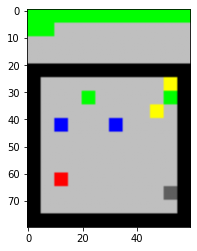

 (0, -1) 3 -1.0 False {'event': 'initialized', 'moves': 0}


KeyboardInterrupt: Interrupted by user

In [47]:
env.reset()
plt.imshow(env.render('rgb_array'))
plt.show()

while True:
    key = input()
    clear_output()
    mapping = {'w': 'up', 'a': 'left', 's': 'down', 'd': 'right'}
    try:
        key = mapping[key]
        dxdy = env.engine.ACTION_NAME_REVERSE[key]
        act = env.engine.ACTIONS_REVERSE[dxdy]
    except:
        print("Wrong action")
    obs, rew, done, info = env.step(act)
    plt.show()
    plt.imshow(env.render('rgb_array'))
    plt.show()
    print(key, dxdy, act, rew, done, info)
    if done:
        env.reset()

In [41]:
env.action_space.sample()

3

In [51]:
env.observation_space

Box(16, 12, 10)